<a href="https://colab.research.google.com/github/brunozanzotti/SkinCancerClassification/blob/main/best_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import os

img_height = 256
img_width = 256
batch_size = 32

# Data augmentation and normalization

datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=[0.7,1.3],
    horizontal_flip=True,
    validation_split=0.05
)

test_datagen = ImageDataGenerator(
    rescale=1.0/255.0
)
# Load and preprocess the images from the directories
train_ds = datagen.flow_from_directory(
    '/content/drive/MyDrive/train 2.0',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',  # 'binary' for binary classification
    subset='training',  # Load the training subset
    shuffle=True
)

val_ds = datagen.flow_from_directory(
    '/content/drive/MyDrive/train 2.0',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation',  # Load the validation subset
    shuffle=True
)

test_ds = test_datagen.flow_from_directory(
    '/content/drive/MyDrive/test 2.0',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

Found 13946 images belonging to 2 classes.
Found 733 images belonging to 2 classes.
Found 715 images belonging to 2 classes.


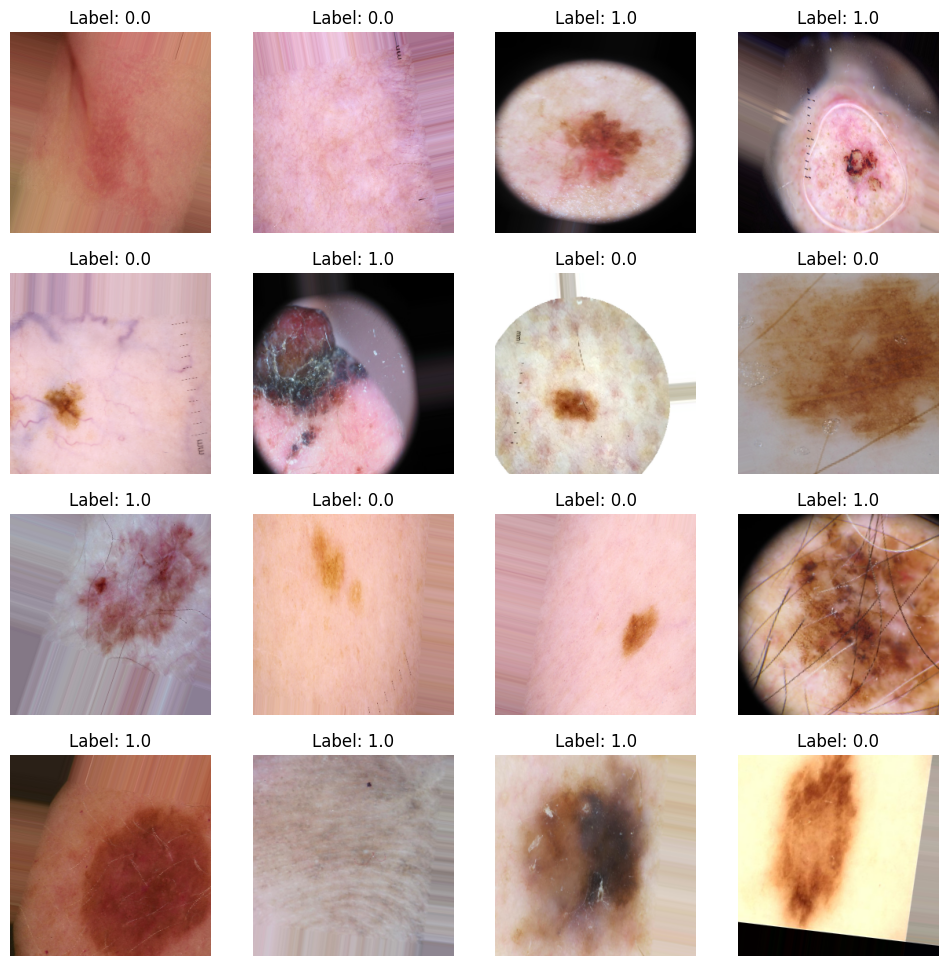

In [2]:
import matplotlib.pyplot as plt

# Get a batch of images from the training dataset
sample_images, sample_labels = next(train_ds)

# Define a function to display the images
def show_images(images, labels):
    plt.figure(figsize=(12, 12))
    for i in range(16):
        plt.subplot(4, 4, i+1)  # Display 16 images in a 4x4 grid
        plt.title(f"Label: {labels[i]}")
        plt.imshow(images[i])
        plt.axis("off")
    plt.show()

# Display a batch of sample images
show_images(sample_images, sample_labels)


In [2]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import  Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

base_model.trainable = True

model = Sequential([
    base_model,
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=3, min_lr=0.000000001)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=10, restore_best_weights=True)

checkpoint_filepath = '/content/drive/MyDrive/checkpoint 4.0/checkpoint.keras'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

model.summary()


94765736/94765736 [==============================] - 5s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 131072)            0         
                                                                 
 dense (Dense)               (None, 512)               67109376  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                         

In [ ]:
history = model.fit(
    train_ds,
    epochs=50,
    validation_data=val_ds,
    callbacks = [model_checkpoint_callback, early_stopping, reduce_lr]
)

Epoch 1/50
436/436 [==============================] - 702s 2s/step - loss: 0.7858 - accuracy: 0.7029 - val_loss: 0.7183 - val_accuracy: 0.5211 - lr: 1.0000e-04
Epoch 2/50
436/436 [==============================] - 664s 2s/step - loss: 0.5038 - accuracy: 0.7891 - val_loss: 0.4489 - val_accuracy: 0.7585 - lr: 1.0000e-04
Epoch 3/50
436/436 [==============================] - 667s 2s/step - loss: 0.4435 - accuracy: 0.8127 - val_loss: 0.3434 - val_accuracy: 0.8076 - lr: 1.0000e-04
Epoch 4/50
436/436 [==============================] - 673s 2s/step - loss: 0.4352 - accuracy: 0.8142 - val_loss: 0.3370 - val_accuracy: 0.8431 - lr: 1.0000e-04
Epoch 5/50
436/436 [==============================] - 669s 2s/step - loss: 0.4368 - accuracy: 0.8151 - val_loss: 0.2659 - val_accuracy: 0.8868 - lr: 1.0000e-04
Epoch 6/50
436/436 [==============================] - 685s 2s/step - loss: 0.3957 - accuracy: 0.8332 - val_loss: 0.3328 - val_accuracy: 0.8745 - lr: 1.0000e-04
Epoch 7/50
436/436 [====================

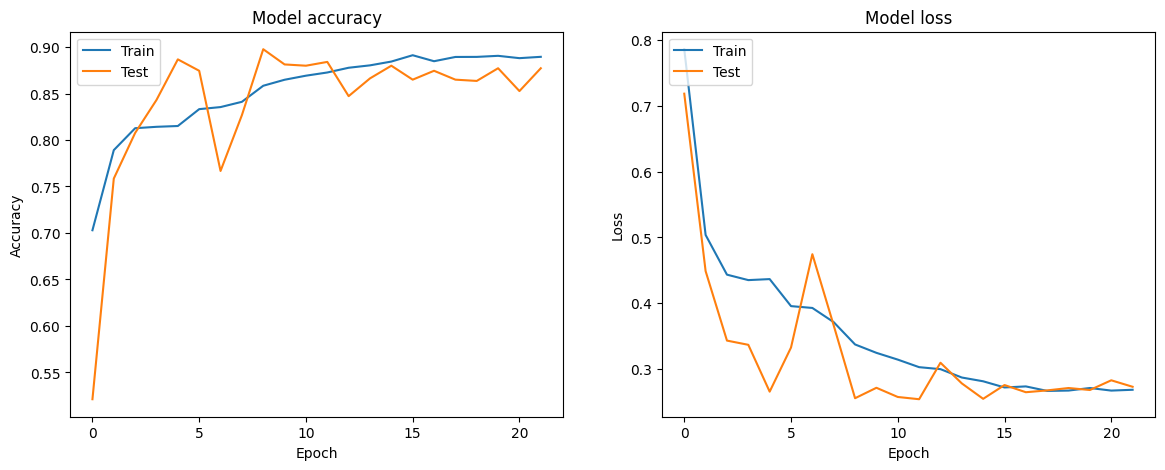

In [ ]:
import matplotlib.pyplot as plt
# Plot training & validation accuracy values
plt.figure(figsize=(14,5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [10]:
model.load_weights('/content/drive/MyDrive/checkpoint 4.0/checkpoint.keras')

In [11]:
loss, accuracy = model.evaluate(test_ds)

print("Test Loss: ", loss)
print("Test Accuracy: ", accuracy)

23/23 [==============================] - 30s 1s/step - loss: 0.2715 - accuracy: 0.8881
Test Loss:  0.271480530500412
Test Accuracy:  0.8881118893623352


In [12]:
  # Generate predictions
predictions_prob = model.predict(test_ds)
predictions_binary = (predictions_prob > 0.5).astype("int32")
# Convert binary predictions to 'benign' and 'malignant'
predictions = ['malignant' if pred == 1 else 'benign' for pred in predictions_binary]
from sklearn.metrics import confusion_matrix
conf_matrix  = confusion_matrix(test_ds.labels, predictions_binary)

23/23 [==============================] - 24s 1s/step


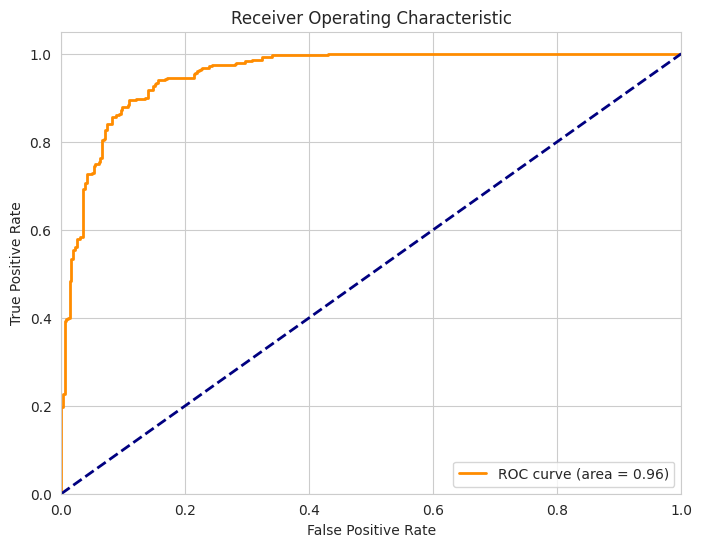

In [16]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(test_ds.classes, predictions_prob)
roc_auc = auc(fpr, tpr)

# Set seaborn style for the plot
sns.set_style("whitegrid")

plt.figure(figsize=(8, 6))
lw = 2

# Plot the ROC curve
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)

# Plot the line of no discrimination
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

# Show the plot
plt.show()


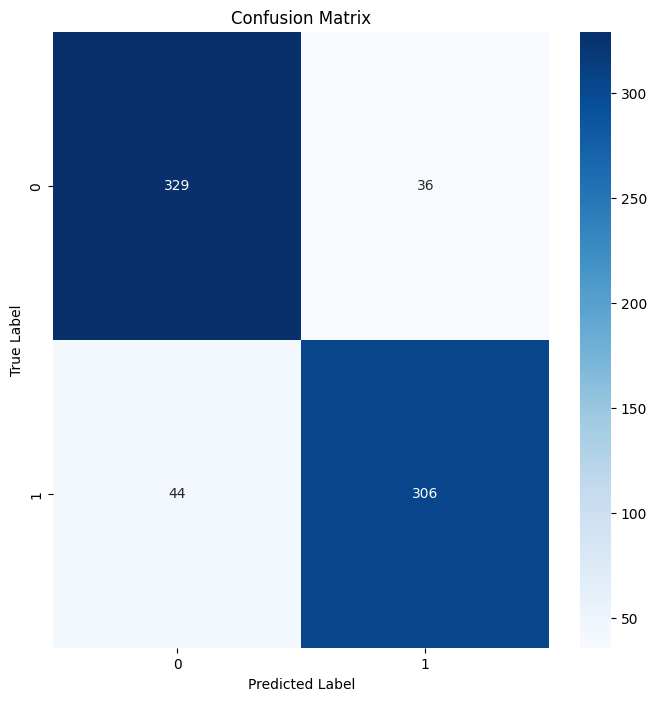

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

labels = [0, 1]

# Plot confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=plt.cm.Blues, xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


In [8]:
from sklearn.metrics import classification_report
report = classification_report(test_ds.labels, predictions_binary)

In [9]:
print(report)

              precision    recall  f1-score   support

           0       0.88      0.90      0.89       365
           1       0.89      0.87      0.88       350

    accuracy                           0.89       715
   macro avg       0.89      0.89      0.89       715
weighted avg       0.89      0.89      0.89       715



In [10]:
import numpy as np

true_labels = test_ds.classes
# Flatten the predictions_binary array
predictions_binary_flattened = predictions_binary.flatten()

# Find the indices of misclassified images
misclassified_indices = np.where(predictions_binary_flattened != true_labels)[0]


# Separate misclassified benign and malignant images
misclassified_benign = [i for i in misclassified_indices if true_labels[i] == 0]
misclassified_malignant = [i for i in misclassified_indices if true_labels[i] == 1]



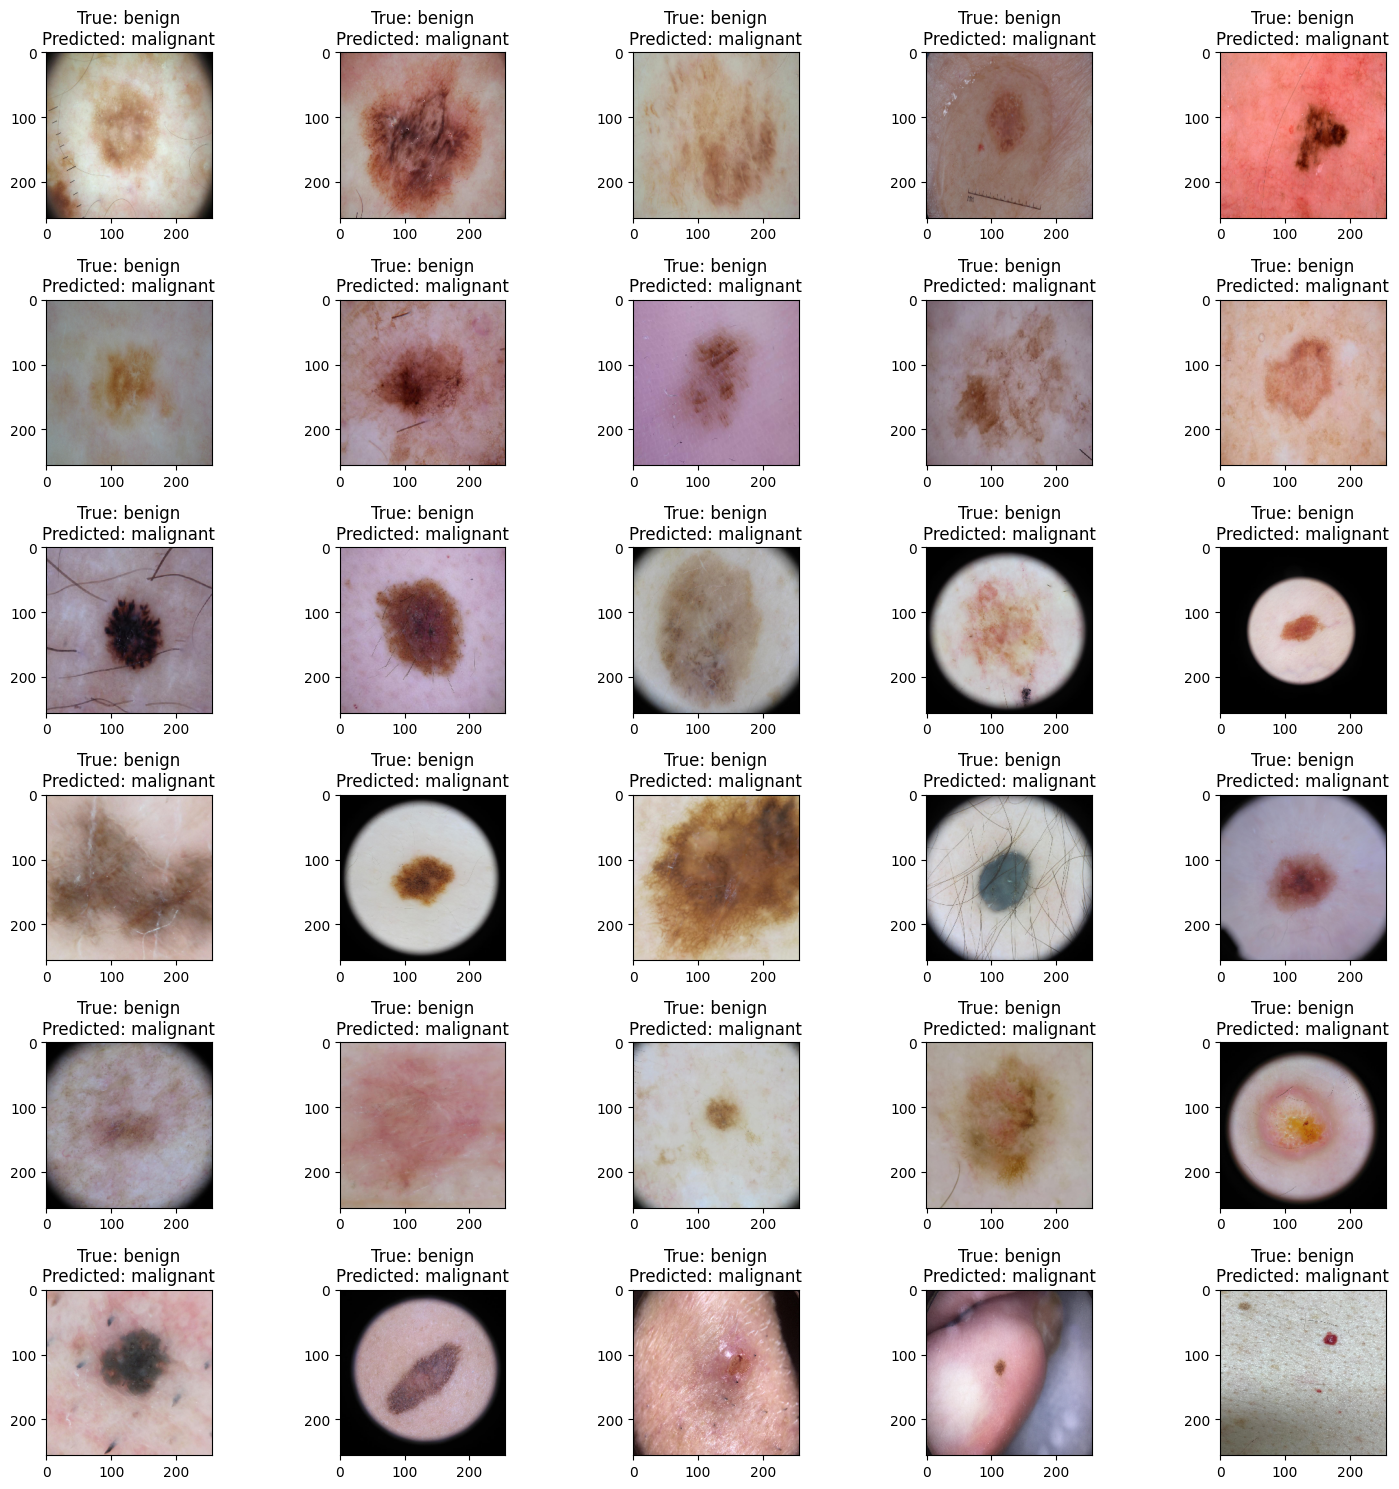

In [12]:
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img

# Number of images to display
num_images = 30

# Create a grid of subplots
fig, axes = plt.subplots(nrows=6, ncols=5, figsize=(15, 15))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Print misclassified benign images
for i, ax in zip(misclassified_benign[:num_images], axes):
    img_path = test_ds.filepaths[i]
    img = load_img(img_path, target_size=(img_height, img_width))
    ax.imshow(img)
    ax.set_title('True: benign\nPredicted: malignant')

# Remove axes for the remaining subplots
for ax in axes[num_images:]:
    ax.axis('off')

# Display the plot
plt.tight_layout()
plt.show()


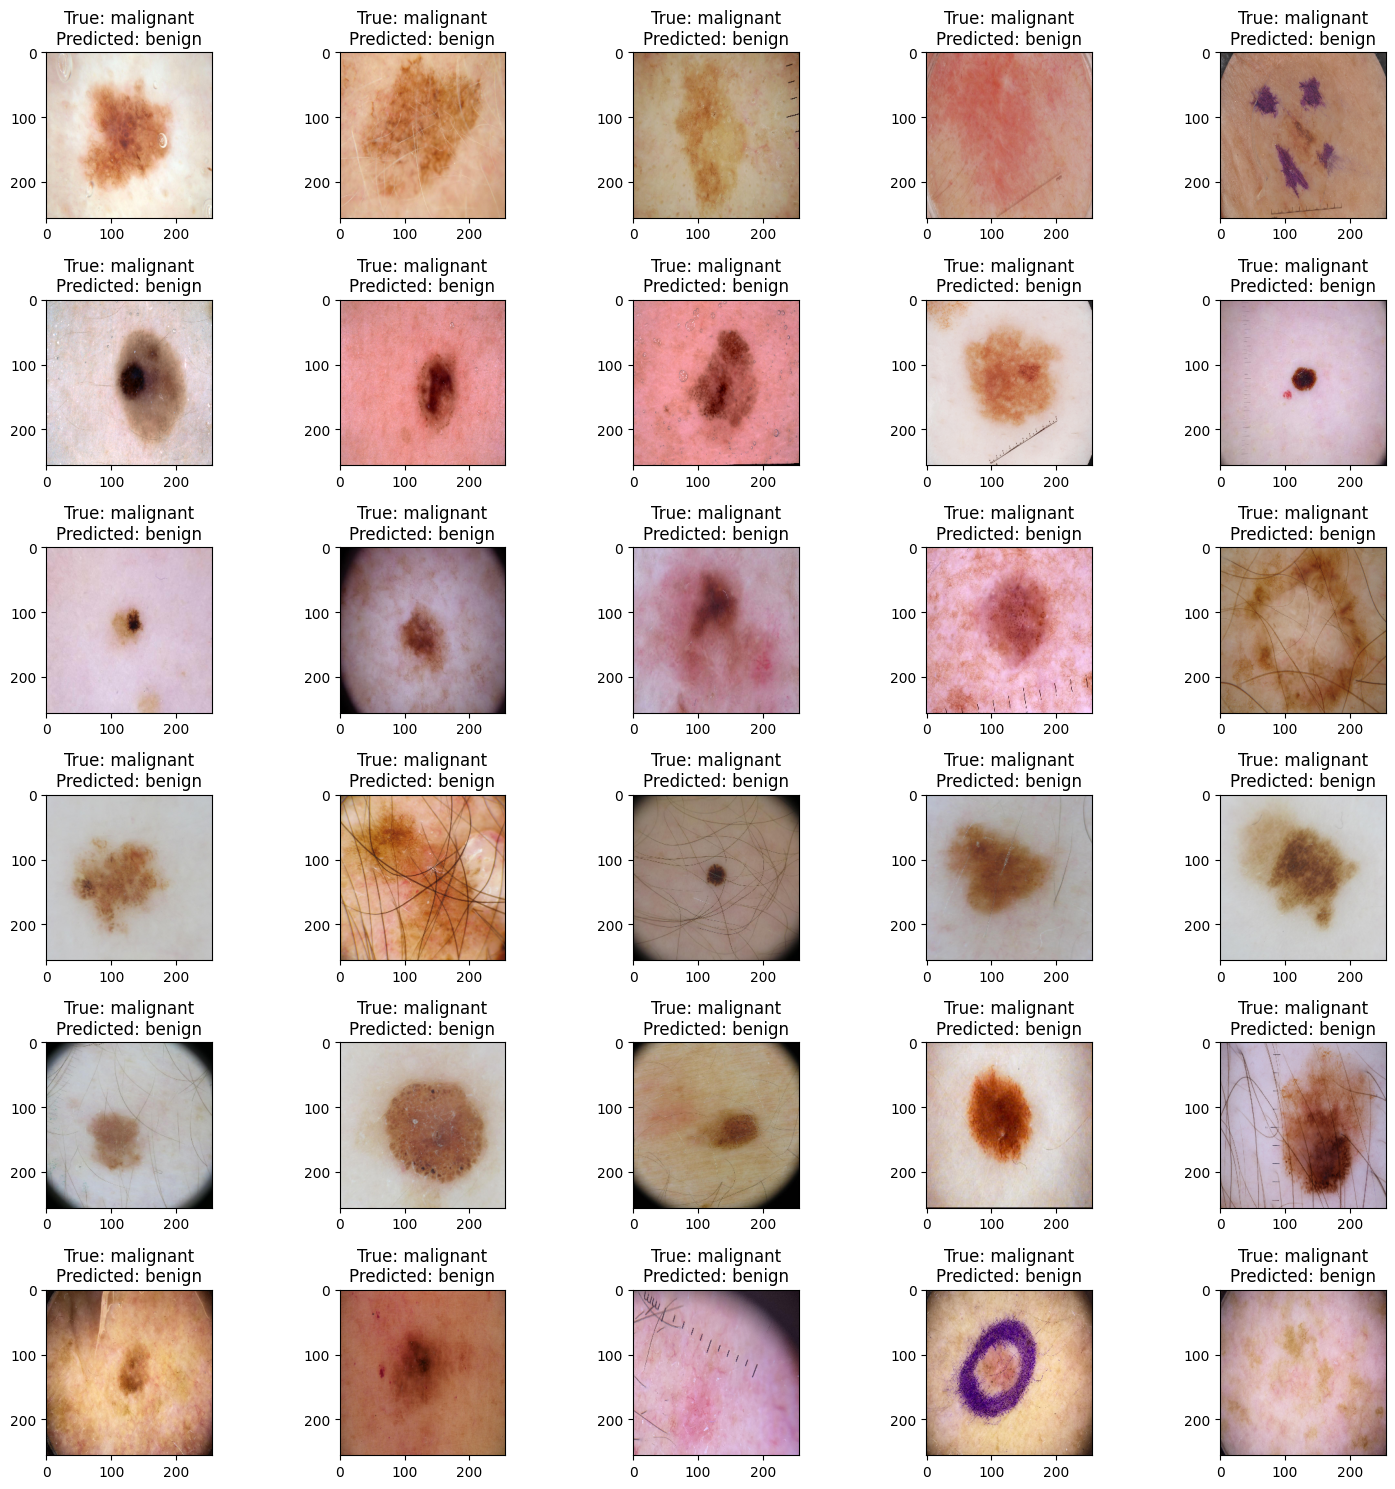

In [13]:
import matplotlib.pyplot as plt

# Number of images to display
num_images = 30

# Create a grid of subplots
fig, axes = plt.subplots(nrows=6, ncols=5, figsize=(15, 15))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Print misclassified benign images
for i, ax in zip(misclassified_malignant[:num_images], axes):
    img_path = test_ds.filepaths[i]
    img = load_img(img_path, target_size=(img_height, img_width))
    ax.imshow(img)
    ax.set_title('True: malignant\nPredicted: benign')

# Remove axes for the remaining subplots
for ax in axes[num_images:]:
    ax.axis('off')

# Display the plot
plt.tight_layout()
plt.show()


In [ ]:
#Training starting with load weights
model.load_weights('/content/drive/MyDrive/final_weights.h5')

reduce_lr_new = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=3, min_lr=0.000000001)

checkpoint_filepath_retrained = '/content/drive/MyDrive/checkpoint_retrined.keras'

model_checkpoint_callback_new = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath_retrained,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)


In [ ]:
history = model.fit(
    train_ds,
    epochs=50,
    validation_data=val_ds,
    callbacks = [model_checkpoint_callback_new, reduce_lr_new]
)

Epoch 1/50
436/436 [==============================] - 4457s 10s/step - loss: 0.3691 - accuracy: 0.8511 - val_loss: 0.3368 - val_accuracy: 0.8745 - lr: 1.0000e-04
Epoch 2/50
436/436 [==============================] - 700s 2s/step - loss: 0.3765 - accuracy: 0.8515 - val_loss: 0.3440 - val_accuracy: 0.8349 - lr: 1.0000e-04
Epoch 3/50
436/436 [==============================] - 702s 2s/step - loss: 0.3815 - accuracy: 0.8486 - val_loss: 0.2864 - val_accuracy: 0.8813 - lr: 1.0000e-04
Epoch 4/50
436/436 [==============================] - 686s 2s/step - loss: 0.3627 - accuracy: 0.8539 - val_loss: 0.2553 - val_accuracy: 0.8990 - lr: 1.0000e-04
Epoch 5/50
436/436 [==============================] - 689s 2s/step - loss: 0.3496 - accuracy: 0.8555 - val_loss: 0.4591 - val_accuracy: 0.7585 - lr: 1.0000e-04
Epoch 6/50
436/436 [==============================] - 699s 2s/step - loss: 0.3392 - accuracy: 0.8657 - val_loss: 0.2845 - val_accuracy: 0.8649 - lr: 1.0000e-04
Epoch 7/50
436/436 [==================

UnknownError: ignored

In [ ]:
model.load_weights('/content/drive/MyDrive/checkpoint_retrined.keras')

In [ ]:
loss, accuracy = model.evaluate(test_ds)

print("Test Loss: ", loss)
print("Test Accuracy: ", accuracy)

23/23 [==============================] - 204s 9s/step - loss: 0.2753 - accuracy: 0.8825
Test Loss:  0.275257408618927
Test Accuracy:  0.8825174570083618


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import os

img_height = 256
img_width = 256
batch_size = 64

# Data augmentation and normalization

datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=[0.7,1.3],
    horizontal_flip=True,
    validation_split=0.05
)

# Load and preprocess the images from the directories
train_ds = datagen.flow_from_directory(
    '/content/drive/MyDrive/Train 3.0',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',  # 'binary' for binary classification
    subset='training',  # Load the training subset
    shuffle=True
)

val_ds = datagen.flow_from_directory(
    '/content/drive/MyDrive/Train 3.0',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation',  # Load the validation subset
    shuffle=True
)

test_ds = datagen.flow_from_directory(
    '/content/drive/MyDrive/test 2.0',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

Found 62712 images belonging to 2 classes.
Found 3300 images belonging to 2 classes.
Found 715 images belonging to 2 classes.


In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import  Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

base_model.trainable = True

model = Sequential([
    base_model,
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=3, min_lr=0.000000001)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=15, restore_best_weights=True)

checkpoint_filepath = '/content/drive/MyDrive/all_images_checkpoint.keras'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 131072)            0         
                                                                 
 dense (Dense)               (None, 512)               67109376  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 32)                4

In [ ]:
history = model.fit(
    train_ds,
    epochs=50,
    validation_data=val_ds,
    callbacks = [model_checkpoint_callback, early_stopping, reduce_lr]
)

Epoch 1/50
199/980 [=====>........................] - ETA: 13:56:19 - loss: 0.6245 - accuracy: 0.8302

UnknownError: ignored

In [ ]:
model.load_weights('/content/drive/MyDrive/final_weights.h5')

In [ ]:
loss, accuracy = model.evaluate(test_ds)

print("Test Loss: ", loss)
print("Test Accuracy: ", accuracy)

23/23 [==============================] - 30s 1s/step - loss: 0.2681 - accuracy: 0.9007
Test Loss:  0.2681361734867096
Test Accuracy:  0.9006993174552917


In [ ]:
predictions_prob_retrained = model.predict(test_ds)
predictions_binary_retrained = (predictions_prob_retrained > 0.52).astype("int32")
# Convert binary predictions to 'benign' and 'malignant'
predictions_retrained = ['malignant' if pred == 1 else 'benign' for pred in predictions_binary_retrained]
from sklearn.metrics import confusion_matrix
conf_matrix  = confusion_matrix(test_ds.labels, predictions_binary_retrained)

23/23 [==============================] - 29s 1s/step


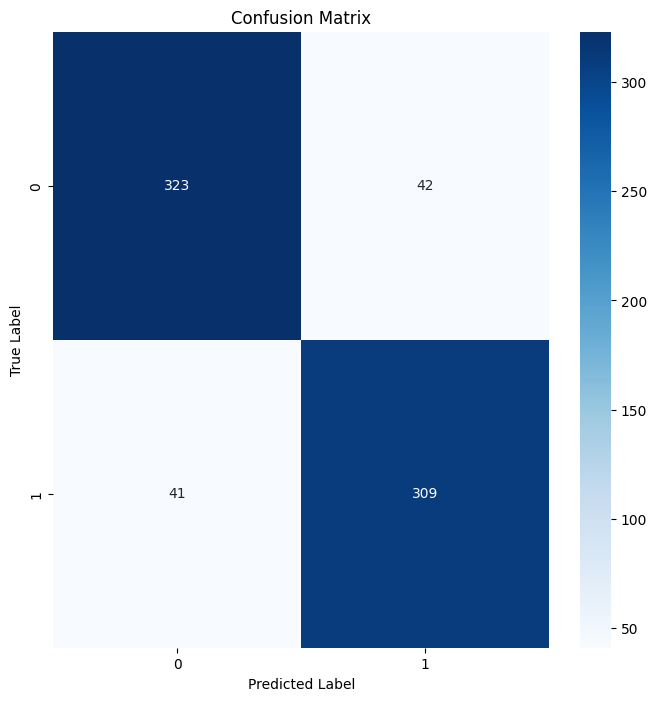

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

labels = [0, 1]

# Plot confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=plt.cm.Blues, xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
from sklearn.metrics import classification_report
report = classification_report(test_ds.labels, predictions_binary_retrained)
print(report)

              precision    recall  f1-score   support

           0       0.89      0.87      0.88       365
           1       0.86      0.89      0.88       350

    accuracy                           0.88       715
   macro avg       0.88      0.88      0.88       715
weighted avg       0.88      0.88      0.88       715



In [ ]:
model.load_weights('/content/drive/MyDrive/final_weights.h5')

In [ ]:
model.evaluate(test_ds)

23/23 [==============================] - 29s 1s/step - loss: 0.2742 - accuracy: 0.8923


[0.274175226688385, 0.892307698726654]

In [ ]:
predictions_prob = model.predict(test_ds)
predictions_binary = (predictions_prob > 0.50).astype("int32")

23/23 [==============================] - 31s 1s/step


In [ ]:
from sklearn.metrics import classification_report
report = classification_report(test_ds.labels, predictions_binary)
print(report)

              precision    recall  f1-score   support

           0       0.90      0.87      0.88       365
           1       0.87      0.89      0.88       350

    accuracy                           0.88       715
   macro avg       0.88      0.88      0.88       715
weighted avg       0.88      0.88      0.88       715

